# Несбалансированные выборки. Практическая работа

## Цель практической работы

Научиться обрабатывать несбалансированные данные и обучать модели машинного обучения на таких данных.

## Что входит в работу


1. Загрузить данные и провести разведочный анализ.
2. Разделить данные на обучающую и тестовую выборки.
3. Подготовить данные для моделирования.
4. Сбалансировать данные методом SMOTE и обучить модель машинного обучения.
5. Обучить модель машинного обучения с использованием весов классов и кросс-валидации.
6. Сравнить метрики качества четырёх моделей.




## Что оценивается

- Выполнены все этапы работы.
- Не допущена утечка данных при разделении выборок и подготовке данных.
- Данные корректным образом сбалансированы.
- Модели не переобучены.


## Как отправить работу на проверку

Скачайте файл с заданиями в материалах, откройте его через Jupyter Notebook и выполните задания. Сохраните изменения при помощи опции Save and Checkpoint из вкладки меню File или кнопки Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (в формате .ipynb) или ссылку на него.


# Задача

Пусть у нас имеется некоторый набор данных `german_credit_data.csv` о заёмщиках банка:

* Age — возраст заёмщика.
* Sex — пол заёмщика.
* Job — тип работы заёмщика.
* Housing — тип жилья заёмщика.
* Saving accounts — объём средств на сберегательных счетах заёмщика.
* Checking account — объём средств на основном счёте заёмщика.
* Credit amount — размер кредита.
* Duration — срок кредита (в месяцах).
* Purpose — цель кредита.
* Risk — таргет, допустил ли заёмщик просрочку платежей по кредиту.

Решите задачу классификации заёмщиков, чтобы банк умел заранее предсказывать просрочку платежей по кредиту.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV

# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [175]:
#from google.colab import drive
#drive.mount('/content/drive')

In [116]:

#df = pd.read_csv('/content/drive/MyDrive/Skillbox/Advanced/Дисбаланс/ data/german_credit_data.csv')
df = pd.read_csv('data/german_credit_data.csv')
df_start = df.copy()
print(df.shape)
print(df.dtypes)
df.head()

(1000, 10)
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [117]:
missing_values = df.isna().sum()
missing_percentage = (missing_values / df.shape[0]) * 100
# Объединяем в один DataFrame
missing_info = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percentage
})
missing_info = missing_info[missing_info['Количество пропусков'] > 0]
print(missing_info)

                  Количество пропусков  Процент пропусков
Saving accounts                    183               18.3
Checking account                   394               39.4


In [118]:
df['Saving accounts'].value_counts()

,count
Saving accounts,
little,603
moderate,103
quite rich,63
rich,48


In [119]:
df['Checking account'].value_counts()

,count
Checking account,
little,274
moderate,269
rich,63


In [120]:
df['Risk'].value_counts()

,count
Risk,
good,700
bad,300


In [121]:
num_cols = df.select_dtypes(include=['number'])
num_cols

,Age,Job,Credit amount,Duration
0,67,2,1169,6
1,22,2,5951,48
2,49,1,2096,12
3,45,2,7882,42
4,53,2,4870,24
...,...,...,...,...
995,31,1,1736,12
996,40,3,3857,30
997,38,2,804,12
998,23,2,1845,45


Histogram for Age


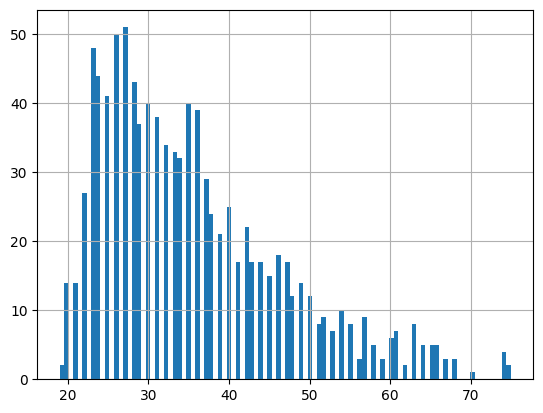

Histogram for Job


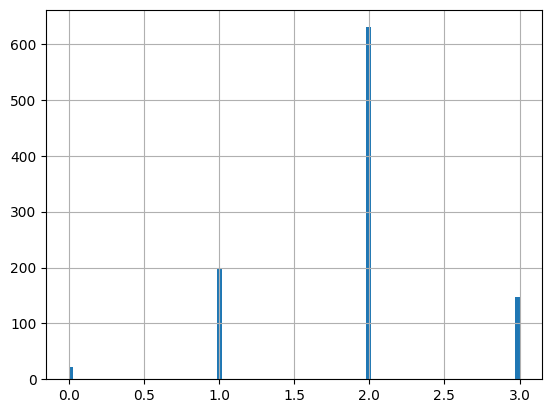

Histogram for Credit amount


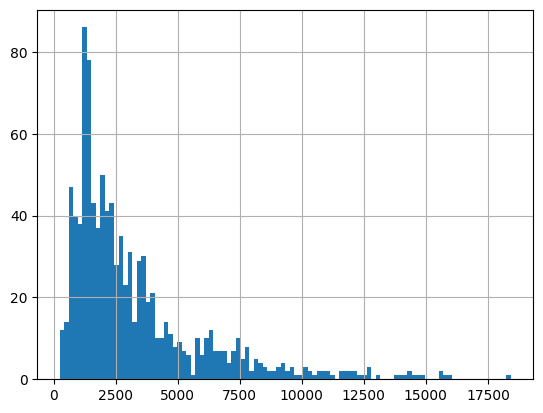

Histogram for Duration


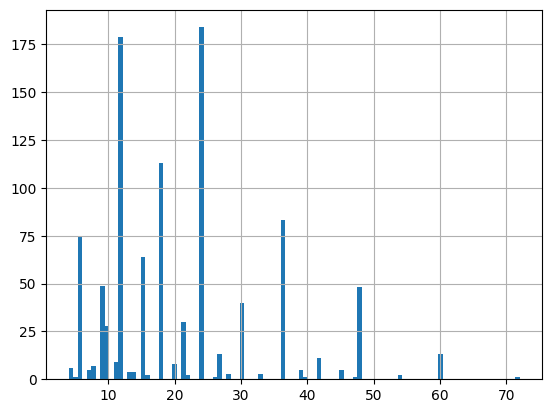

In [122]:
for col in num_cols:
  print(f'Histogram for {col}')
  df[col].hist(bins=100)
  plt.show()

# Задание 2

Разделите датасет на обучающую и тестовую выборки в пропорции 80:20. Разделение должно быть стратифицированным по таргету Risk.

В этом и следующих заданиях используйте random_state = 1.

In [123]:
df_train, df_test = train_test_split(df, stratify=df['Risk'], test_size=0.2, random_state=1)

# Задание 3

Проведите этап очистки и подготовки данных (data preparation) и подготовьте данные к моделированию.

Пропуски

In [124]:
print(df['Checking account'].value_counts())
print(df['Saving accounts'].value_counts())

Checking account
little      274
moderate    269
rich         63
Name: count, dtype: int64
Saving accounts
little        603
moderate      103
quite rich     63
rich           48
Name: count, dtype: int64


In [125]:
# # Исходя из значений переменных 'Saving accounts', 'Checking account' предположим что NAN говорит об отсутствии
to_other = ['Saving accounts', 'Checking account']

# Проверка на наличие NaN
print("Количество пропусков перед импресией:")
print(df_train[to_other].isnull().sum())

# Обработка NaN
imputer_other = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='other')
df_train[to_other] = imputer_other.fit_transform(df_train[to_other])

# Проверка на наличие NaN после импресии
print("Количество пропусков после импресии:")
print(df_train[to_other].isnull().sum())

Количество пропусков перед импресией:
Saving accounts     143
Checking account    307
dtype: int64
Количество пропусков после импресии:
Saving accounts     0
Checking account    0
dtype: int64


In [126]:
# сразу обработаем test

# Проверка на наличие NaN
print("Количество пропусков перед импресией:")
print(df_test[to_other].isnull().sum())

# Обработка NaN
imputer_other = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='other')
df_test[to_other] = imputer_other.fit_transform(df_test[to_other])

# Проверка на наличие NaN после импресии
print("Количество пропусков после импресии:")
print(df_test[to_other].isnull().sum())

Количество пропусков перед импресией:
Saving accounts     40
Checking account    87
dtype: int64
Количество пропусков после импресии:
Saving accounts     0
Checking account    0
dtype: int64


Выбросы и аномалии

In [127]:
def calculate_iqr_boundaries(series):
  q25 = series.quantile(0.25)
  q75 = series.quantile(0.75)
  iqr = q75 - q25

  boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
  return boundaries

------- Age -------
Размах (4.5, 64.5)
Количество выбросов 0 23
=======+++++++=======
------- Job -------
Размах (2.0, 2.0)
Количество выбросов 222 148
=======+++++++=======
------- Credit amount -------
Размах (-2544.625, 7882.375)
Количество выбросов 0 72
=======+++++++=======
------- Duration -------
Размах (-6.0, 42.0)
Количество выбросов 0 70
=======+++++++=======


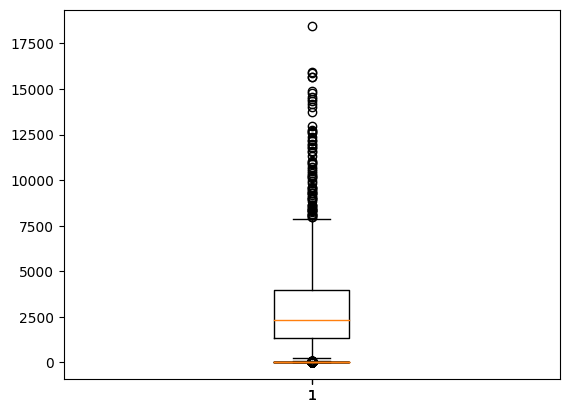

In [128]:
num_cols = df_train.select_dtypes(include=['number'])

for i in num_cols:
    bounds = calculate_iqr_boundaries(df[i])
    out_l = sum(df[i] < bounds[0])
    out_r = sum(df[i] > bounds[1])
    print('-------', i, '-------')
    print('Размах', bounds)
    print('Количество выбросов', out_l, out_r)
    plt.boxplot(df[i])
    #plt.show()
    print('=======+++++++=======')

In [129]:
# Age, Credit amount, Duration. Выбросы заменим на граничные квантильного размаха
to_quant = ['Age', 'Credit amount', 'Duration']


num_cols_list = df_train[to_quant]
for i in num_cols_list:
    print('======', i, '=====')
    lower_bound, upper_bound = calculate_iqr_boundaries(df_train[i])

    out_l = df_train[df_train[i] < lower_bound]  # Строки с левыми выбросами
    out_r = df_train[df_train[i] > upper_bound]  # Строки с правыми выбросами

    # ИЛИ МЕДИАНУ
    #median_income = df[i].median()
    # Заменяем выбросы на медиану
    #df[i] = df[i].apply(lambda x: median_income if x < lower_bound or x > upper_bound else x)

    # Заменяем выбросы на граничные значения
    df_train[i] = df_train[i].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))


    # После замены, пересчитываем границы
    lower_bound, upper_bound = calculate_iqr_boundaries(df_train[i])

    # Проверяем оставшиеся выбросы
    out_l = df_train[df_train[i] < lower_bound]  # Строки с левыми выбросами
    out_r = df_train[df_train[i] > upper_bound]  # Строки с правыми выбросами

    print('Размах', (lower_bound, upper_bound))
    print('Количество выбросов слева:', len(out_l))
    print('Количество выбросов справа:', len(out_r))
    print('Общее количество значений:', sum(df_train[i].value_counts()))

    if not out_l.empty:
        print('Выбросы слева:')
        #print(out_l)

    if not out_r.empty:
        print('Выбросы справа:')
        #print(out_r)

    print('=======+++++++=======')

====== Age =====
Размах (4.5, 64.5)
Количество выбросов слева: 0
Количество выбросов справа: 0
Общее количество значений: 800
=======+++++++=======
====== Credit amount =====
Размах (-2412.25, 7717.75)
Количество выбросов слева: 0
Количество выбросов справа: 0
Общее количество значений: 800
=======+++++++=======
====== Duration =====
Размах (-6.0, 42.0)
Количество выбросов слева: 0
Количество выбросов справа: 0
Общее количество значений: 800
=======+++++++=======


In [130]:
# сразу обработаем test
num_cols = df_test.select_dtypes(include=['number'])

# Age, Credit amount, Duration. Выбросы заменим на граничные квантильного размаха
to_quant = ['Age', 'Credit amount', 'Duration']


num_cols_list = df_test[to_quant]
for i in num_cols_list:
    print('======', i, '=====')
    lower_bound, upper_bound = calculate_iqr_boundaries(df_test[i])

    out_l = df_test[df_test[i] < lower_bound]  # Строки с левыми выбросами
    out_r = df_test[df_test[i] > upper_bound]  # Строки с правыми выбросами

    # ИЛИ МЕДИАНУ
    #median_income = df[i].median()
    # Заменяем выбросы на медиану
    #df[i] = df[i].apply(lambda x: median_income if x < lower_bound or x > upper_bound else x)

    # Заменяем выбросы на граничные значения
    df_test[i] = df_test[i].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))


    # После замены, пересчитываем границы
    lower_bound, upper_bound = calculate_iqr_boundaries(df_test[i])

    # Проверяем оставшиеся выбросы
    out_l = df_test[df_test[i] < lower_bound]  # Строки с левыми выбросами
    out_r = df_test[df_test[i] > upper_bound]  # Строки с правыми выбросами

    print('Размах', (lower_bound, upper_bound))
    print('Количество выбросов слева:', len(out_l))
    print('Количество выбросов справа:', len(out_r))
    print('Общее количество значений:', sum(df_test[i].value_counts()))

    if not out_l.empty:
        print('Выбросы слева:')
        #print(out_l)

    if not out_r.empty:
        print('Выбросы справа:')
        #print(out_r)

    print('=======+++++++=======')

====== Age =====
Размах (6.5, 58.5)
Количество выбросов слева: 0
Количество выбросов справа: 0
Общее количество значений: 200
=======+++++++=======
====== Credit amount =====
Размах (-3662.375, 9466.625)
Количество выбросов слева: 0
Количество выбросов справа: 0
Общее количество значений: 200
=======+++++++=======
====== Duration =====
Размах (-6.0, 42.0)
Количество выбросов слева: 0
Количество выбросов справа: 0
Общее количество значений: 200
=======+++++++=======


In [131]:
df_train.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
561,24.0,male,1,rent,little,little,1546.00,24.0,radio/TV,bad
613,22.0,female,2,rent,little,little,3632.00,24.0,car,good
352,38.0,male,3,own,other,other,3229.00,18.0,car,good
568,41.0,male,2,own,other,moderate,3979.00,42.0,radio/TV,good
295,26.0,female,2,own,little,moderate,7717.75,42.0,furniture/equipment,bad


#### Нормализация и кодирование признаков

In [ ]:
# Нормализацию численных признаков для деревьев делать НЕ будем

#### Будем пробовать два варианта кодирования категориальных переменных

df_train_h - Категориальные признаки закодируем вручную

df_train_encoded - Закодируем в OneHotEncoder

In [132]:
# Категориальные признаки закодируем вручную
df_train_h = df_train.copy()
df_train_encoded = df_train.copy()

In [133]:
# сразу обработаем тест
df_test_h = df_test.copy()
df_test_encoded = df_test.copy()

In [134]:
df_train_h['Sex'].value_counts()

,count
Sex,
male,551
female,249


In [135]:
# Замена значений Sex
df_train_h['Sex'] = df_train_h['Sex'].map({'female': 0, 'male': 1})

df_test_h['Sex'] = df_test_h['Sex'].map({'female': 0, 'male': 1})

In [136]:
df_train_h['Housing'].value_counts()

,count
Housing,
own,563
rent,149
free,88


In [137]:
# Замена значений Housing
df_train_h['Housing'] = df_train_h['Housing'].replace({'own': 3, 'rent': 1, 'free': 0})

df_test_h['Housing'] = df_test_h['Housing'].replace({'own': 3, 'rent': 1, 'free': 0})

df_train_h['Housing'].value_counts()

,count
Housing,
3,563
1,149
0,88


In [138]:
df_train_h['Saving accounts'].value_counts()

,count
Saving accounts,
little,485
other,143
moderate,90
quite rich,46
rich,36


In [139]:
replacement_dict = {
    'little': 1,
    'other': 0,
    'moderate': 2,
    'quite rich': 4,
    'rich': 3
}

In [140]:

# Замена значений
df_train_h['Saving accounts'] = df_train_h['Saving accounts'].replace(replacement_dict)

df_test_h['Saving accounts'] = df_test_h['Saving accounts'].replace(replacement_dict)

In [141]:
df_train_h['Checking account'].value_counts()

,count
Checking account,
other,307
little,222
moderate,217
rich,54


In [142]:

# Замена значений
df_train_h['Checking account'] = df_train_h['Checking account'].replace(replacement_dict)

df_test_h['Checking account'] = df_test_h['Checking account'].replace(replacement_dict)

In [143]:
df_train_h['Purpose'].value_counts()

,count
Purpose,
car,274
radio/TV,216
furniture/equipment,143
business,80
education,51
repairs,16
domestic appliances,10
vacation/others,10


In [144]:
# Определяем последовательность замены

purpose_mapping = {
    'car': 6,
    'radio/TV': 1,
    'furniture/equipment': 2,
    'business': 7,
    'education': 5,
    'repairs': 4,
    'domestic appliances': 0,
    'vacation/others': 3
}

In [145]:
# Заменяем значения в столбце 'Purpose'
df_train_h['Purpose'] = df_train_h['Purpose'].map(purpose_mapping)

df_test_h['Purpose'] = df_test_h['Purpose'].map(purpose_mapping)

In [146]:
# Замена значений Risk
#df_train_h['Risk'] = df_train_h['Risk'].map({'bad': 0, 'good': 1})

In [147]:
df_train_h.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
561,24.0,1,1,1,1,1,1546.00,24.0,1,bad
613,22.0,0,2,1,1,1,3632.00,24.0,6,good
352,38.0,1,3,3,0,0,3229.00,18.0,6,good
568,41.0,1,2,3,0,2,3979.00,42.0,1,good
295,26.0,0,2,3,1,2,7717.75,42.0,2,bad


Применим OneHonEncoder

In [148]:
to_encode = df_train_encoded.select_dtypes(include=['object']).drop(['Risk'], axis=1)
to_encode

,Sex,Housing,Saving accounts,Checking account,Purpose
561,male,rent,little,little,radio/TV
613,female,rent,little,little,car
352,male,own,other,other,car
568,male,own,other,moderate,radio/TV
295,female,own,little,moderate,furniture/equipment
...,...,...,...,...,...
59,female,rent,little,little,furniture/equipment
397,male,own,little,little,furniture/equipment
227,male,free,little,little,furniture/equipment
128,male,own,little,moderate,car


In [149]:
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# Применение OneHotEncoder
encoded_features = encoder.fit_transform(to_encode)

# Преобразование результата обратно в DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(to_encode.columns))


# Сброс индексов
df_train_encoded.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# Объединение с сбросом индексов
df_train_encoded = pd.concat([df_train_encoded, encoded_df], axis=1)


# Удаление оригинальных столбцов
df_train_encoded = df_train_encoded.drop(columns=to_encode.columns)

print(df_train_encoded)

      Age  Job  Credit amount  Duration  Risk  Sex_male  Housing_own  \
0    24.0    1        1546.00      24.0   bad       1.0          0.0   
1    22.0    2        3632.00      24.0  good       0.0          0.0   
2    38.0    3        3229.00      18.0  good       1.0          1.0   
3    41.0    2        3979.00      42.0  good       1.0          1.0   
4    26.0    2        7717.75      42.0   bad       0.0          1.0   
..    ...  ...            ...       ...   ...       ...          ...   
795  23.0    1        6229.00      36.0   bad       0.0          0.0   
796  46.0    2        2348.00      36.0  good       1.0          1.0   
797  53.0    3        7717.75      12.0   bad       1.0          0.0   
798  34.0    3        1860.00      12.0  good       1.0          1.0   
799  50.0    1        1047.00       6.0  good       0.0          1.0   

     Housing_rent  Saving accounts_moderate  Saving accounts_other  ...  \
0             1.0                       0.0                 

In [150]:
# используем ранее обученный энкодер на тест
to_encode = df_test_encoded.select_dtypes(include=['object']).drop(['Risk'], axis=1)

encoded_features = encoder.transform(to_encode)

# Преобразование результата обратно в DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(to_encode.columns))


# Сброс индексов
df_test_encoded.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# Объединение с сбросом индексов
df_test_encoded = pd.concat([df_test_encoded, encoded_df], axis=1)


# Удаление оригинальных столбцов
df_test_encoded = df_test_encoded.drop(columns=to_encode.columns)

print(df_test_encoded)

      Age  Job  Credit amount  Duration  Risk  Sex_male  Housing_own  \
0    36.0    2       2799.000       9.0  good       1.0          0.0   
1    35.0    2        976.000      12.0  good       1.0          1.0   
2    58.5    2       6761.000      18.0   bad       1.0          0.0   
3    30.0    2       1224.000       9.0  good       1.0          1.0   
4    50.0    2       6224.000      42.0   bad       1.0          0.0   
..    ...  ...            ...       ...   ...       ...          ...   
195  32.0    2       4594.000      18.0  good       1.0          1.0   
196  24.0    2       9466.625      36.0   bad       1.0          1.0   
197  34.0    3       6614.000      36.0  good       1.0          1.0   
198  26.0    2       1934.000      12.0  good       1.0          1.0   
199  58.5    3       6468.000      20.0  good       1.0          1.0   

     Housing_rent  Saving accounts_moderate  Saving accounts_other  ...  \
0             1.0                       0.0                 

# Задание 4

Сбалансируйте обучающую выборку методом SMOTE и обучите модель RandomForestClassifier. Подберите оптимальные гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.

In [151]:
os = SMOTE(random_state=1, k_neighbors=2)

features = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose']
target = 'Risk'

X_train, y_train = os.fit_resample(df_train_h[features], df_train_h[target])

In [152]:
y_train.value_counts()

,count
Risk,
bad,560
good,560


In [153]:
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)

X_test, y_test = df_test_h[features], df_test_h[target]
print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

0.7564285714285715


Сделаем то-же самое на данных с OneHotEncoder

In [154]:
df_train_encoded.columns

Index(['Age', 'Job', 'Credit amount', 'Duration', 'Risk', 'Sex_male',
       'Housing_own', 'Housing_rent', 'Saving accounts_moderate',
       'Saving accounts_other', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_moderate',
       'Checking account_other', 'Checking account_rich', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others'],
      dtype='object')

In [155]:
os_enc = SMOTE(random_state=1, k_neighbors=2)

features_enc = ['Age', 'Job', 'Credit amount', 'Duration', 'Sex_male',       'Housing_own', 'Housing_rent', 'Saving accounts_moderate',
       'Saving accounts_other', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_moderate',
       'Checking account_other', 'Checking account_rich', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others']
target = 'Risk'

X_train, y_train = os_enc.fit_resample(df_train_encoded[features_enc], df_train_encoded[target])

In [156]:
model_enc = RandomForestClassifier(random_state=1)
model_enc.fit(X_train, y_train)

X_test, y_test = df_test_encoded[features_enc], df_test_encoded[target]
print(roc_auc_score(y_test, model_enc.predict_proba(X_test)[:, 1]))

smote = roc_auc_score(y_test, model_enc.predict_proba(X_test)[:, 1])

0.7599999999999999


#### GridSearch

In [157]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

In [158]:
model = RandomForestClassifier(random_state=1)

# Настройка
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)


grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC AUC:", grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Лучшие параметры: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Лучший ROC AUC: 0.902311862244898


In [159]:
best_model = grid_search.best_estimator_

X_test, y_test = df_test_encoded[features_enc], df_test_encoded[target]
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print("ROC AUC на тестовых данных:", roc_auc)

smote_grid = roc_auc

ROC AUC на тестовых данных: 0.7716666666666666


# Задание 5

Обучите модель RandomForestClassifier с использованием весов классов. Подберите оптимальные веса и гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.

In [160]:
df_train_h[df_train_h['Risk'] == 'bad'].shape

(240, 10)

In [161]:
df_train_h[df_train_h['Risk'] == 'good'].shape

(560, 10)

In [162]:
df_train_h['Risk'].value_counts()

,count
Risk,
good,560
bad,240


In [163]:
class_weights = {
    'good': 1,
    'bad': (df_train_h[df_train_h['Risk'] == 'good'].shape[0] / df_train_h[df_train_h['Risk'] == 'bad'].shape[0]) ** 2
}
class_weights

{'good': 1, 'bad': 5.4444444444444455}

In [164]:
y_train

,Risk
0,bad
1,good
2,good
3,good
4,bad
...,...
1115,bad
1116,bad
1117,bad
1118,bad


In [165]:
X_train, y_train = df_train_h[features], df_train_h[target]

model = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=1, class_weight=class_weights)

model.fit(X_train, y_train)

X_test, y_test = df_test_h[features], df_test_h[target]
print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

0.7788690476190476


In [166]:
model_w_gr = RandomForestClassifier(random_state=1, class_weight=class_weights)

# Настройка
grid_search = GridSearchCV(estimator=model_w_gr, param_grid=param_grid,
                           scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)


grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC AUC:", grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Лучшие параметры: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Лучший ROC AUC: 0.7535714285714286


In [167]:
best_model = grid_search.best_estimator_

X_test, y_test = df_test_h[features], df_test_h[target]
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print("ROC AUC на тестовых данных:", roc_auc)

ROC AUC на тестовых данных: 0.7758333333333334


Сделаем то-же самое на кодированных данных

In [168]:
df_train_encoded['Risk'].value_counts()

,count
Risk,
good,560
bad,240


In [170]:
class_weights = {
    'good': 1,
    'bad': (df_train_encoded[df_train_encoded['Risk'] == 'good'].shape[0] / df_train_h[df_train_h['Risk'] == 'bad'].shape[0]) ** 2
}
class_weights

{'good': 1, 'bad': 5.4444444444444455}

In [171]:
X_train, y_train = df_train_encoded[features_enc], df_train_encoded[target]

model_w_enc = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=1, class_weight=class_weights)

model_w_enc.fit(X_train, y_train)

X_test, y_test = df_test_encoded[features_enc], df_test_encoded[target]
print(roc_auc_score(y_test, model_w_enc.predict_proba(X_test)[:, 1]))

weight = roc_auc_score(y_test, model_w_enc.predict_proba(X_test)[:, 1])

0.74875


In [172]:
model_w_gr_enc = RandomForestClassifier(random_state=1, class_weight=class_weights)

# Настройка
grid_search = GridSearchCV(estimator=model_w_gr_enc, param_grid=param_grid,
                           scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)


grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC AUC:", grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Лучшие параметры: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Лучший ROC AUC: 0.7503348214285713


In [173]:
best_model = grid_search.best_estimator_

X_test, y_test = df_test_encoded[features_enc], df_test_encoded[target]
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print("ROC AUC на тестовых данных:", roc_auc)

weight_grid = roc_auc

ROC AUC на тестовых данных: 0.7842857142857143


Выводы по проделанной работе:

Заполнение пропусков: Предположено, что пропуски в данных обусловлены отсутствием значения и были заменены на 'other'.

Выбросы: значения выбросов были заменены на граничные значения 0.25 и 0.75 квантилей.

Нормализация числовых переменных: Не производилась. Поскольку для древовидных моделей в данной нормализации нет необходимости.

Кодирование категориальных признаков:
Использовались два варианта кодирования. Ручное кодирование, значениям придавались числовые значения.
OneHotEncoder, использовался параметр drop_first.

Разделение на train и test произведено до обработки данных. Обработка train и test производилась паралельно. В случае использования препроцессоров, тестовые данные кодировались на обученном на трейн препроцессоре.

Что касается кодирования категориальных признаков. Модели обученные на кодированных в OneHotEncoder данных показали лучший результат.

Лучшая модель, по метрике roc_auc показала -0.7842857142857143.
Параметры лучшей модели -
RandomForestClassifier
RandomForestClassifier(class_weight={'bad': 5.4444444444444455, 'good': 1}, max_depth=10, min_samples_split=10, n_estimators=200, random_state=1)

In [174]:

# Сравнение метрик roc_auc моделей

print('roc_auc модели: SMOTE = ', smote)
print('roc_auc модели: SMOTE+GridSearch = ', smote_grid)
print('roc_auc модели: CLASS_WEIGHT = ', weight)
print('roc_auc модели: CLASS_WEIGHT +GridSearch = ', weight_grid)

roc_auc модели: SMOTE =  0.7599999999999999
roc_auc модели: SMOTE+GridSearch =  0.7716666666666666
roc_auc модели: CLASS_WEIGHT =  0.74875
roc_auc модели: CLASS_WEIGHT +GridSearch =  0.7842857142857143
